# Proyecto
## Clasificación de Sonidos Urbanos

**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Deep Learning**

---
### Integrantes:
- Diego Leiva
- Pablo Orellana
- Maria Marta Ramirez
---

# Demo

## Librerias

In [1]:
# Datos
import numpy as np

# Visualización
import matplotlib.pyplot as plt
from IPython.display import Audio

# Torch
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

# Utils
import random
import platform

# Audio
import librosa

# Advertencias
import warnings
warnings.filterwarnings("ignore") # Ignorar advertencias

## Configuracion de PyTorch CUDA

In [2]:
# Semilla para reproducibilidad
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configuración de determinismo
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_info = ""

# Configuración de dispositivo
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device_info = f'{torch.cuda.get_device_name(0)}'
else:
    device_info = f"{platform.processor()}"

print(f"Device: {device_info}")

Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Pipeline del DEMO

### Arquitectura

In [3]:
class AudioLSTM(nn.Module):
    def __init__(self, feature_size, out_features, hidden_layers, layers, dropout):
        super().__init__()
        self.n_hidden = hidden_layers
        self.n_layers = layers
        self.n_feature = feature_size

        # Capa LSTM
        self.lstm = nn.LSTM(
            input_size=self.n_feature,
            hidden_size=self.n_hidden,
            num_layers=self.n_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True
        )

        # Aplicar mecanismo de atención
        self.attention = nn.Sequential(
            nn.Linear(self.n_hidden * 2, self.n_hidden),
            nn.Tanh(),
            nn.Linear(self.n_hidden, 1)
        )

        # Capa de dropout
        self.dropout = nn.Dropout(dropout)

        # Primer capa lineal con batch normalization
        self.fc1 = nn.Linear(self.n_hidden * 2, self.n_hidden)
        self.batch_norm1 = nn.BatchNorm1d(self.n_hidden)
        
        # Segunda capa lineal con batch normalization
        self.fc2 = nn.Linear(self.n_hidden, int(self.n_hidden/2))
        self.batch_norm2 = nn.BatchNorm1d(int(self.n_hidden/2))
        
        # Capa de salida
        self.fc3 = nn.Linear(int(self.n_hidden/2), out_features)

    # Attention mechanism
    def attention_net(self, lstm_output):
        # Obtener el tamaño de la secuencia 
        attention_weights = self.attention(lstm_output)
        attention_weights = F.softmax(attention_weights, dim=1)

        # Aplicar atención a la salida de la LSTM
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector

    # Forward pass
    def forward(self, x, hidden):
        # X shape -> (batch_size, sequence_length, n_features)
        # Salida de la capa LSTM
        l_out, l_hidden = self.lstm(x, hidden)

        # Aplicar mecanismo de atención
        attn_out = self.attention_net(l_out)

        # Out shape -> (batch_size, sequence_length, n_hidden*direcction)
        # Aplicar Dropout a la salida de la capa LSTM
        out = self.dropout(attn_out)
        
        identity = out
        # Paso a través de la primera capa lineal
        out = self.fc1(out) # Tomar la salida de la capa LSTM con atención
        out = self.batch_norm1(out)  # Aplicar batch normalization

        # Aplicar función de activación ReLU
        out = F.relu(out)

        # Paso a través de la segunda capa lineal
        out = self.fc2(out)
        out = self.batch_norm2(out)

        # Aplicar función de activación ReLU
        out = F.relu(out)

        # Aplicar dropout
        out = self.dropout(out)

        # Paso a través de la capa de salida
        out = self.fc3(out)
        
        # Retornar el output y el hidden state
        return out, l_hidden
    

    # Inicializar hidden state
    def init_hidden(self, batch_size):
        # Obtener pesos de la primera capa
        weight = next(self.parameters()).data

        # Inicializar hidden state con ceros
        hidden = (weight.new(self.n_layers * 2, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers * 2, batch_size, self.n_hidden).zero_().to(device))
        
        # Retornar hidden state
        return hidden

### Carga del modelo entrenado

In [4]:
# Cargar el modelo
def load_model(model_path, feature_size, out_features, hidden_layers, layers, dropout):
    model = AudioLSTM(feature_size=feature_size, 
                      out_features=out_features, 
                      hidden_layers=hidden_layers, 
                      layers=layers, 
                      dropout=dropout).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

### Preprocesamiento de Audio

In [5]:
# Preprocesar el archivo de audio
def preprocess_audio(file_path, audio_length=160000):
    waveform, _ = torchaudio.load(file_path, normalize=True)
    mono = torch.mean(waveform, dim=0, keepdim=True)
    temp = torch.zeros([1, audio_length])
    if mono.numel() < audio_length:
        temp[:, :mono.numel()] = mono
    else:
        temp = mono[:, :audio_length]
    audio_mono = temp

    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=22050,
        n_fft=2048,
        win_length=1024,
        hop_length=512,
        n_mels=128,
        f_min=20,
        f_max=11025
    )

    mel_spectrogram = mel_spec(audio_mono)
    mel_spectrogram_norm = (mel_spectrogram - mel_spectrogram.mean()) / (mel_spectrogram.std() + 1e-7)
    feature_vector = mel_spectrogram_norm[0].permute(1, 0).clone().detach()

    return feature_vector.unsqueeze(0).to(device)

### Predicciones

In [6]:
# Predecir la clase de un archivo de audio
def predict(file_path, model, class_mapping):
    input_data = preprocess_audio(file_path)
    hidden = model.init_hidden(batch_size=1)
    with torch.no_grad():
        output, _ = model(input_data, hidden)
        predicted_class_idx = output.argmax(dim=1).item()
    predicted_class = class_mapping[predicted_class_idx]
    return predicted_class

## DEMO

### Mapeo de clases

In [7]:
class_mapping = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music"
}

### Carga del modelo entrenado con toda la data

In [8]:
# Ruta del modelo guardado
model_path = 'models/lstmv2_full.pth'

# Cargar el modelo
model = load_model(model_path, 
                    feature_size=128, 
                    out_features=10, 
                    hidden_layers=256, 
                    layers=2, 
                    dropout=0.3)

### Input

In [9]:
# Archivo de prueba
audio_file = input("Ingrese la ruta del archivo de audio: ")

# Cargar el archivo de audio
audio_data, sample_rate = librosa.load(audio_file)

# Datos del archivo de audio
print(f"Sampling rate: {sample_rate} Hz")
print(f"Número de muestras: {len(audio_data)}")
print(f"Duracion: {len(audio_data)/sample_rate} segundos")

# Incrustar el archivo de audio
Audio(filename=audio_file, autoplay=True)

Sampling rate: 22050 Hz
Número de muestras: 98200
Duracion: 4.453514739229025 segundos


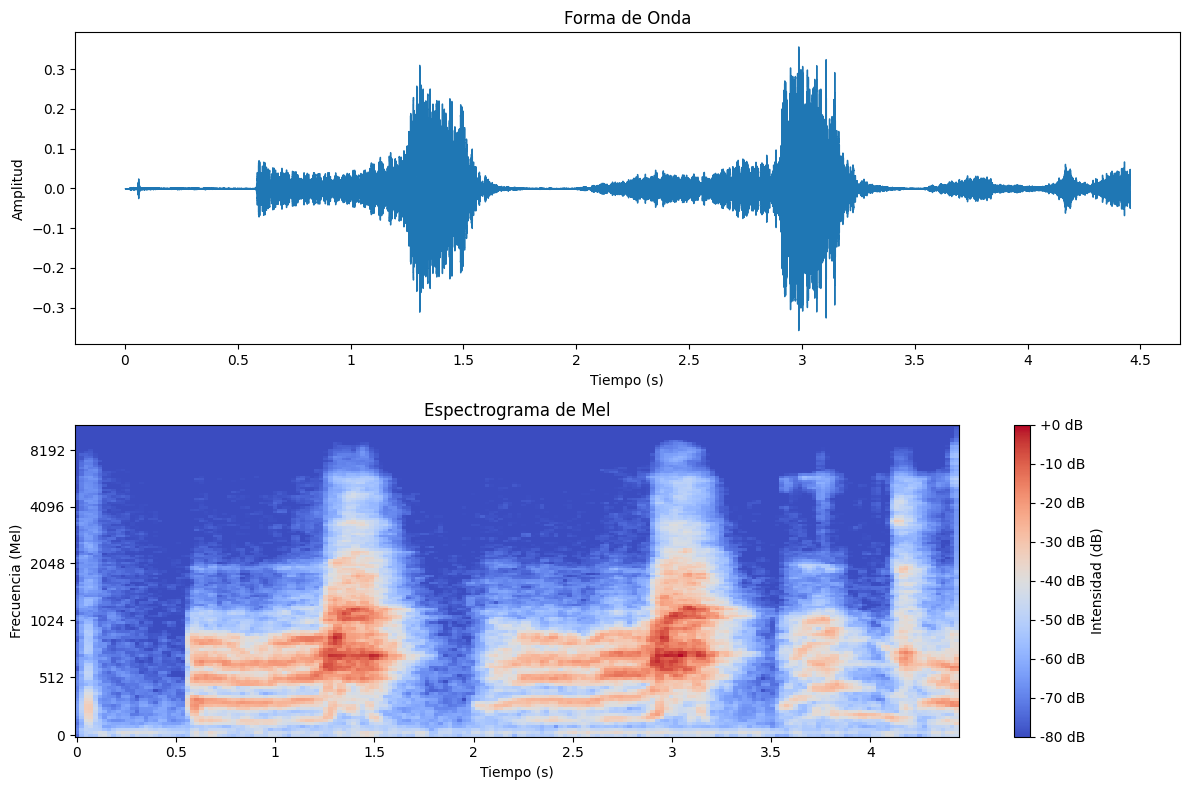

In [ ]:
# Calcular el espectrograma de Mel
mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=sample_rate//2)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


# Crear el gráfico combinado
plt.figure(figsize=(12, 8))

# Subplot 1: Forma de onda
plt.subplot(2, 1, 1)
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.title('Forma de Onda')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

# Subplot 2: Espectrograma de Mel
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB', label='Intensidad')
plt.title('Espectrograma de Mel')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Mel)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Prediccion

In [11]:
predicted_class = predict(audio_file, model, class_mapping)
print(f"Predicción: {predicted_class}")

Predicción: dog_bark
